In [71]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import string
import pickle
import numpy as np
from datetime import datetime
import seaborn as sns
import os


## Data Preprocessing

In [61]:
df = pd.read_csv('final_data.csv')

#lowercase
df['text'] = df['text'].apply(lambda x: x.lower())

#punctuations removal
def punctuation_removal(text):
    return text.translate(str.maketrans('','',string.punctuation))
df['text'] = df['text'].apply(punctuation_removal)

#stopwords removal
stopwords_lst = stopwords.words('english')
def stopwords_removal(text):
    text_lst = text.split()
    text_lst = [word for word in text_lst if word.lower() not in stopwords_lst]
    text = ' '.join(text_lst)
    return text
df['text'] = df['text'].apply(stopwords_removal)

#lemmatization
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmawords = [lemmatizer.lemmatize(w) for w in text.split()]
    text = ' '.join(lemmawords)
    return text
df['text'] = df['text'].apply(lemmatize)

#format the date to datetime64
df['created_utc'] = df.apply(lambda row : datetime.strptime(row['created_utc'],"%Y-%m-%d %H:%M:%S.%f"), axis = 1)

#extract week of the year info
df['week'] = df.apply(lambda row : row['created_utc'].strftime('%W'), axis = 1)

#modify week 0 to week 1
df.loc[df['week'] == '00','week'] = '01'

#extract month info
df['month'] = df.apply(lambda row : row['created_utc'].strftime('%m'), axis = 1)

df

created_utc  \
0       2021-01-01 00:00:06.000000   
1       2021-01-01 00:06:59.000000   
2       2021-01-01 00:09:22.000000   
3       2021-01-01 00:35:21.000000   
4       2021-01-01 00:37:12.000000   
...                            ...   
466564  2021-12-31 23:48:14.000000   
466565  2021-12-31 23:49:50.000000   
466566  2021-12-31 23:50:42.000000   
466567  2021-12-31 23:53:38.000000   
466568  2021-12-31 23:58:38.000000   

                                                     text   source  
0       zaoyang it’s company bought young exapple engi...  Twitter  
1       aapl stock according analyst good investment 2...  Twitter  
2       yes legitimately got free stock microsoft refe...  Twitter  
3       without apple partnership nio still new year b...  Twitter  
4       captaincanucks8 either one good ended nvidia s...  Twitter  
...                                                   ...      ...  
466564                                          40 years😂  Youtube  
466565  probably gonna get back stock trading anytime ...  Twitter  
466566  tonesim jfreerivers omg really think like mean...  Twitter  
466567  “cinnamon apple sauce special today seems we’r...  Twitter  
466568  started small amount 2k lost 50 month 200 gain...   Reddit  

[466569 rows x 3 columns]

In [58]:
#preprocessing function before running data into LSTM model

def preprocess(sentences):
    # Setting tokenizer properties
    vocab_size = 24500
    oov_tok = "<oov>"

    # Fit the tokenizer on Training data
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(sentences)

    # Setting the padding properties
    sequence_length = 300 #longest text is 271 in training dataset
    trunc_type='post'
    padding_type='post'

    # Creating padded sequences from train and test data
    sequences = tokenizer.texts_to_sequences(sentences)
    sequences_padded = pad_sequences(sequences, maxlen=sequence_length, padding=padding_type, truncating=trunc_type)

    
    #convert train data to numpy array
    x_padded = np.array(sequences_padded)
    return x_padded

## Processs Text Dataframe for monthly sentiment analysis

In [62]:
#jan
df_jan = df.loc[df['created_utc']<'2021-02-01 00:00:00']
#feb
df_feb = df.loc[df['created_utc']<'2021-03-01 00:00:00']
df_feb = df_feb.loc[df['created_utc']>='2021-02-01 00:00:00']
#march
df_march = df.loc[df['created_utc']<'2021-04-01 00:00:00']
df_march = df_march.loc[df['created_utc']>='2021-03-01 00:00:00']
#april
df_april = df.loc[df['created_utc']<'2021-05-01 00:00:00']
df_april = df_april.loc[df['created_utc']>='2021-04-01 00:00:00']
#may
df_may = df.loc[df['created_utc']<'2021-06-01 00:00:00']
df_may = df_may.loc[df['created_utc']>='2021-05-01 00:00:00']
#june
df_june = df.loc[df['created_utc']<'2021-07-01 00:00:00']
df_june = df_june.loc[df['created_utc']>='2021-06-01 00:00:00']
#july
df_july = df.loc[df['created_utc']<'2021-08-01 00:00:00']
df_july = df_july.loc[df['created_utc']>='2021-07-01 00:00:00']
#august
df_aug = df.loc[df['created_utc']<'2021-09-01 00:00:00']
df_aug = df_aug.loc[df['created_utc']>='2021-08-01 00:00:00']
#sept
df_sept = df.loc[df['created_utc']<'2021-10-01 00:00:00']
df_sept = df_sept.loc[df['created_utc']>='2021-09-01 00:00:00']
#oct
df_oct = df.loc[df['created_utc']<'2021-11-01 00:00:00']
df_oct = df_oct.loc[df['created_utc']>='2021-10-01 00:00:00']
#nov
df_nov = df.loc[df['created_utc']<'2021-12-01 00:00:00']
df_nov = df_nov.loc[df['created_utc']>='2021-11-01 00:00:00']
#dec
df_dec = df.loc[df['created_utc']<'2021-12-01 23:59:99']
df_dec = df_dec.loc[df['created_utc']>='2021-12-01 00:00:00']
df_dec


created_utc  \
434587  2021-12-01 00:00:17.000000   
434588  2021-12-01 00:00:24.000000   
434589  2021-12-01 00:00:37.000000   
434590  2021-12-01 00:00:49.000000   
434591  2021-12-01 00:02:17.000000   
...                            ...   
435844  2021-12-01 23:55:01.000000   
435845  2021-12-01 23:55:01.000000   
435846  2021-12-01 23:56:43.000000   
435847  2021-12-01 23:59:04.000000   
435848  2021-12-01 23:59:22.000000   

                                                     text   source  
434587                microsoft stock ceo dump share msft  Youtube  
434588                                                      Reddit  
434589  🔥🚀aapl aapl apple call option opened morning 🔴...  Twitter  
434590                                      slaughterfest  Youtube  
434591                  yikes prop whoever front ran post   Reddit  
...                                                   ...      ...  
435844  johnmu said last week stock page google see so...  Twitter  
435845  hangout last week johnmu explained google see ...  Twitter  
435846                      look like family held hostage  Youtube  
435847  aapl stock set new alltime high iphone 13 line...  Twitter  
435848                                   aapl let go 🚀🚀🚀🚀   Reddit  

[1262 rows x 3 columns]

In [63]:
df_by_month_lst = [df_jan, df_feb, df_march, df_april, df_may, df_june, df_july, df_aug, df_sept, df_oct, df_nov, df_dec]

## Processs Text Dataframe for weekly sentiment analysis

In [66]:
weekly_text = {}
for i in range(1,53):
    num = str(i)
    if len(num)==1:
        num = '0'+ num
    temp_df = df[df['week']==num] #get weekly dataframe
    weekly_text[i] = list(temp_df['text'])

weekly_text

{1: ['zaoyang it’s company bought young exapple engineer rival cisco developing market bought stock year ago 20 share robertpera still household name even though he’s worth 16b 42 year old httpstcofnnokhndnz',
  'aapl stock according analyst good investment 2021 stock stockmarketnews mercadolibre httpstcofa3nt9jyig httpstcobaercj7se5',
  'yes legitimately got free stock microsoft referring mom bro free fuckin money',
  'without apple partnership nio still new year buy long term nio stock look like bargain 48 per shareinvestorplace nio nio nioglobal niogang nionation blueskycoming robinhoodapp webullglobal cnevpost reuters httpstcoo5hr07btfy',
  'captaincanucks8 either one good ended nvidia stock believe dl much important long run',
  'pltr astronaut pltr good value moon potential 🚀🚀🚀🚀',
  'trade pltr currently i’d invest right scenario i’m asking people bullish',
  'angieti heb huge grocer annual what’s kinda thingy look new product stock tick google em may another opportunity spread p

## LSTM Sentiment Prediction by month

In [6]:
#load model
lstm = load_model('LSTM.h5')

2022-04-14 20:06:56.665620: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [68]:
#sentiment by month
classes = ['Neutral', 'Positive', 'Negative'] #-1: [0,0,1], 0: [1,0,0], 1: [0,1,0]
sentiment_month_lst = []

for i in range(12):
    print(f'running month {i+1}')
    sentences = list(df_by_month_lst[i]['text'])
    padded_sequences = preprocess(sentences)
    y_prob = lstm.predict(padded_sequences)
    y_classes = y_prob.argmax(axis=-1)
    sentiment_month_lst.append(classes[max(set(list(y_classes)), key = list(y_classes).count)])

running month 1
Positive
running month 2
Positive
running month 3
Positive
running month 4
Positive
running month 5
Positive
running month 6
Positive
running month 7
Positive
running month 8
Positive
running month 9
Positive
running month 10
Positive
running month 11
Positive
running month 12
Positive


## LSTM Sentiment Prediction by week

In [70]:
classes = ['Neutral', 'Positive', 'Negative'] #-1: [0,0,1], 0: [1,0,0], 1: [0,1,0]
sentiment_weekly_lst = []

for i in range(1,53):
    print(f'running week {i}')
    sentences = weekly_text[i]
    padded_sequences = preprocess(sentences)
    y_prob = lstm.predict(padded_sequences)
    y_classes = y_prob.argmax(axis=-1)
    sentiment_weekly_lst.append(classes[max(set(list(y_classes)), key = list(y_classes).count)])

sentiment_weekly_lst

running week 1
Positive
running week 2
Positive
running week 3
Positive
running week 4
Positive
running week 5
Positive
running week 6
Positive
running week 7
Positive
running week 8
Positive
running week 9
Positive
running week 10
Positive
running week 11
Positive
running week 12
Positive
running week 13
Positive
running week 14
Positive
running week 15
Positive
running week 16
Positive
running week 17
Positive
running week 18
Positive
running week 19
Positive
running week 20
Positive
running week 21
Positive
running week 22
Positive
running week 23
Positive
running week 24
Positive
running week 25
Positive
running week 26
Positive
running week 27
Positive
running week 28
Positive
running week 29
Positive
running week 30
Positive
running week 31
Positive
running week 32
Positive
running week 33
Positive
running week 34
Positive
running week 35
Positive
running week 36
Positive
running week 37
Positive
running week 38
Positive
running week 39
Positive
running week 40
Positive
running w

['Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive']

## Sentiment Analysis with top 10 stocks

In [73]:
#dataframe preprocessing function
def process_stock_df(dataframe):
    #converting to datetime format
    dataframe['Date'] = dataframe.apply(lambda row : datetime.strptime(row['Date'],"%Y-%m-%d"), axis = 1)

    #extract week of the year info
    dataframe['week'] = dataframe.apply(lambda row : row['Date'].strftime('%W'), axis = 1)

    #extract month info
    dataframe['month'] = dataframe.apply(lambda row : row['Date'].strftime('%m'), axis = 1)

    #add new column for change in daily price
    dataframe['%change'] = dataframe['Close'].pct_change()*100

    #averaging %change by month and week
    month_dataframe = pd.DataFrame(dataframe.groupby(['month'])['%change'].mean().reset_index())
    week_dataframe = pd.DataFrame(dataframe.groupby(['week'])['%change'].mean().reset_index())
    
    return [month_dataframe, week_dataframe]

## Process top 10 stocks historical share price

In [98]:
stock_dir = r'historical share price/top 10 companies'

stocks_path_lst = os.listdir(stock_dir)
stock_names = [stock.split('.csv')[0] for stock in stocks_path_lst]
stocks_path_lst = [stock_dir + '/' + stock for stock in stocks_path_lst]

stocks_dict = {}
for i in range(len(stock_names)):
    path = stocks_path_lst[i]
    name = stock_names[i]
    if '.DS_Store' in path:
        continue

    temp_df = pd.read_csv(path)
    temp_month_df, temp_week_df = process_stock_df(temp_df)
    stocks_dict[name] = [temp_month_df, temp_week_df]

stocks_dict

{'CSCO': [   month   %change
  0     01  0.081022
  1     02  0.043941
  2     03  0.631050
  3     04 -0.070337
  4     05  0.198533
  5     06  0.012966
  6     07  0.211675
  7     08  0.296212
  8     09 -0.380912
  9     10  0.138258
  10    11 -0.082227
  11    12  0.718449,
     week   %change
  0    01  0.621040
  1    02  0.166374
  2    03 -0.364336
  3    04 -0.080058
  4    05  1.529156
  5    06 -0.319617
  6    07 -0.859520
  7    08 -0.354946
  8    09  0.628374
  9    10  1.091301
  10   11  0.069142
  11   12  1.441821
  12   13 -0.279223
  13   14  0.043932
  14   15  0.277360
  15   16 -0.334515
  16   17 -0.386621
  17   18  0.977990
  18   19 -0.189683
  19   20 -0.176566
  20   21  0.182391
  21   22  0.550766
  22   23  0.261208
  23   24 -1.004574
  24   25  0.382360
  25   26  0.180908
  26   27  0.095949
  27   28 -0.011218
  28   29  0.567639
  29   30  0.052389
  30   31  0.082498
  31   32  0.315351
  32   33  0.630245
  33   34  0.275168
  34   35  0.13587

## LSTM - Top 10 Stocks Analysis Monthly

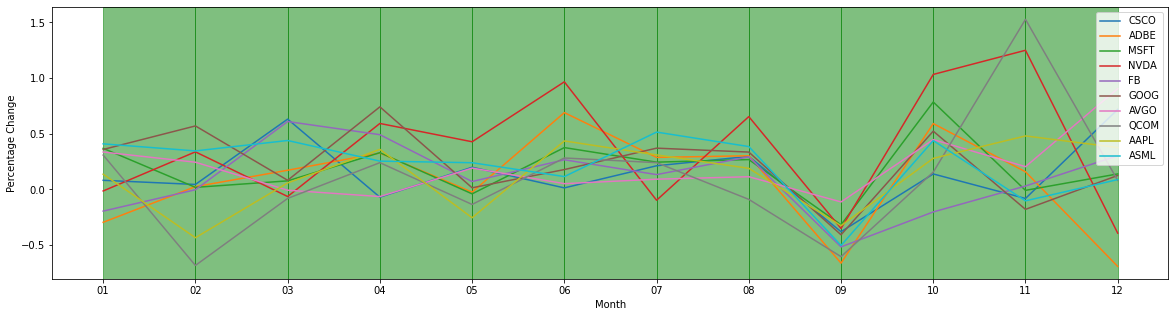

In [148]:
for name in stocks_dict.keys():
    if '.DS_Store' in name:
        continue
   
    change_price = stocks_dict[name][0]['%change']
    month = stocks_dict[name][0]['month'] 
    plt.plot(month, change_price, label = name)
    
for index, sentiment in enumerate(sentiment_month_lst):
    
    if sentiment =='Positive':
        color = 'green'
    elif sentiment == 'Negative':
        color = 'red'
    else:
        color = 'grey'
    
    if index == len(sentiment_month_lst)-1:
        continue
    startx = index
    endx = index+1
    
    plt.axvspan(startx,endx, color = color, alpha=0.5)    

plt.rcParams["figure.figsize"] = (20,5)
plt.ylabel('Percentage Change')
plt.xlabel('Month')
plt.legend(loc = 'upper right')

## LSTM - Top 10 Stocks Analysis Weekly

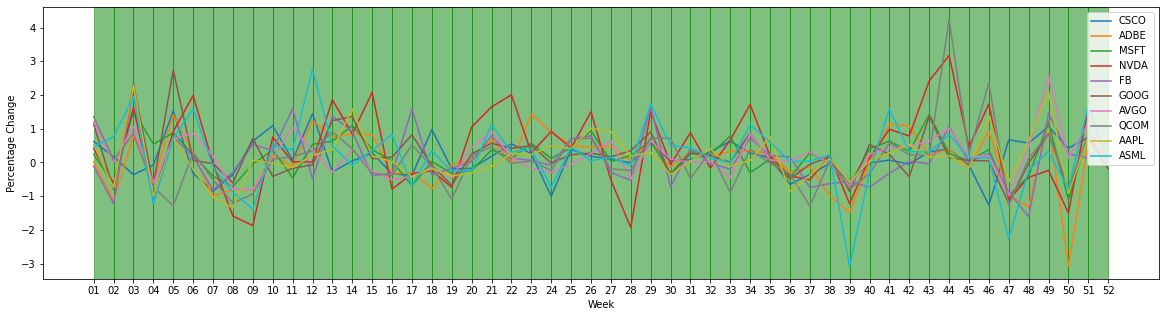

In [149]:
for name in stocks_dict.keys():
    if '.DS_Store' in name:
        continue
   
    change_price = stocks_dict[name][1]['%change']
    week = stocks_dict[name][1]['week'] 
    plt.plot(week, change_price, label = name)

for index, sentiment in enumerate(sentiment_weekly_lst):
    
    if sentiment =='Positive':
        color = 'green'
    elif sentiment == 'Negative':
        color = 'red'
    else:
        color = 'grey'
    
    if index == len(sentiment_weekly_lst)-1:
        continue
    startx = index
    endx = index+1
    
    plt.axvspan(startx,endx, color = color, alpha=0.5)  
   
plt.rcParams["figure.figsize"] = (20,5)
plt.ylabel('Percentage Change')
plt.xlabel('Week')
plt.legend(loc = 'upper right')

## Vader - Top 10 Stocks Analysis Monthly

In [159]:
vader_df = pd.read_csv('vader_df.csv')

#averaging %change by month and week
month_textdf = pd.DataFrame(vader_df.groupby(['month'])['sentiment'].mean().reset_index())
week_textdf = pd.DataFrame(vader_df.groupby(['week'])['sentiment'].mean().reset_index())

In [160]:
month_textdf.describe()

month  sentiment
count  12.000000  12.000000
mean    6.500000   0.168575
std     3.605551   0.017920
min     1.000000   0.128236
25%     3.750000   0.158991
50%     6.500000   0.175027
75%     9.250000   0.179427
max    12.000000   0.189410

In [166]:
week_textdf.describe()

week  sentiment
count  53.000000  53.000000
mean   26.000000   0.172509
std    15.443445   0.024790
min     0.000000   0.094471
25%    13.000000   0.158376
50%    26.000000   0.175852
75%    39.000000   0.186249
max    52.000000   0.222921

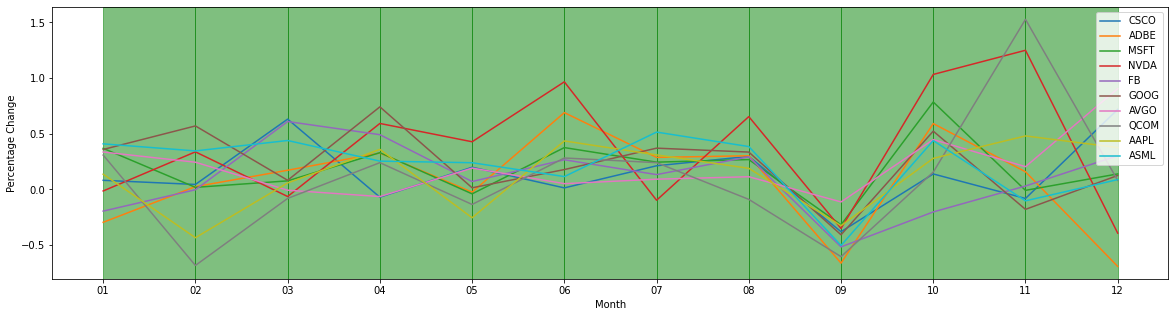

In [162]:
for name in stocks_dict.keys():
    if '.DS_Store' in name:
        continue
   
    change_price = stocks_dict[name][0]['%change']
    month = stocks_dict[name][0]['month']
    
    plt.plot(month, change_price, label = name)

for month in month_textdf['month']:
    sentiment = month_textdf.loc[month_textdf['month'] == int(month), 'sentiment'].iloc[0]
    if sentiment >= 0.05:
        color = 'green'
    elif sentiment<=-0.05:
        color = 'red'
    else:
        color = 'grey'
    
    if int(month) == 12:
        continue
    startx = int(month)-1
    endx = int(month)
    
    plt.axvspan(startx,endx, color = color, alpha=0.5)
    
plt.rcParams["figure.figsize"] = (20,5)
plt.ylabel('Percentage Change')
plt.xlabel('Month')
plt.legend(loc = 'upper right')


## Vader - Top 10 Stocks Analysis Weekly

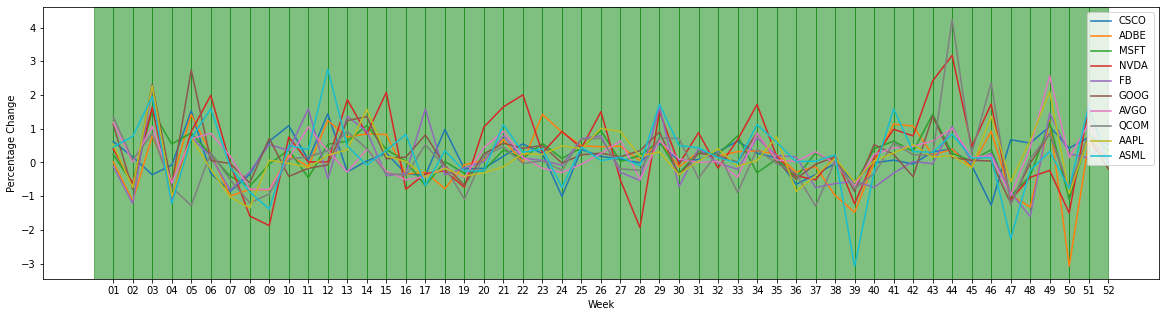

In [164]:
for name in stocks_dict.keys():
    if '.DS_Store' in name:
        continue
   
    change_price = stocks_dict[name][1]['%change']
    week = stocks_dict[name][1]['week']
    
    plt.plot(week, change_price, label = name)

for week in week_textdf['week']:
    sentiment = week_textdf.loc[week_textdf['week'] == int(week), 'sentiment'].iloc[0]
    if sentiment >= 0.05:
        color = 'green'
    elif sentiment<=-0.05:
        color = 'red'
    else:
        color = 'grey'
    
    if int(week) == 52:
        continue
    startx = int(week)-1
    endx = int(week)
    
    plt.axvspan(startx,endx, color = color, alpha=0.5)
    
plt.rcParams["figure.figsize"] = (20,5)
plt.ylabel('Percentage Change')
plt.xlabel('Week')
plt.legend(loc = 'upper right')

## VADER - Top 10 Stocks adjusted monthly

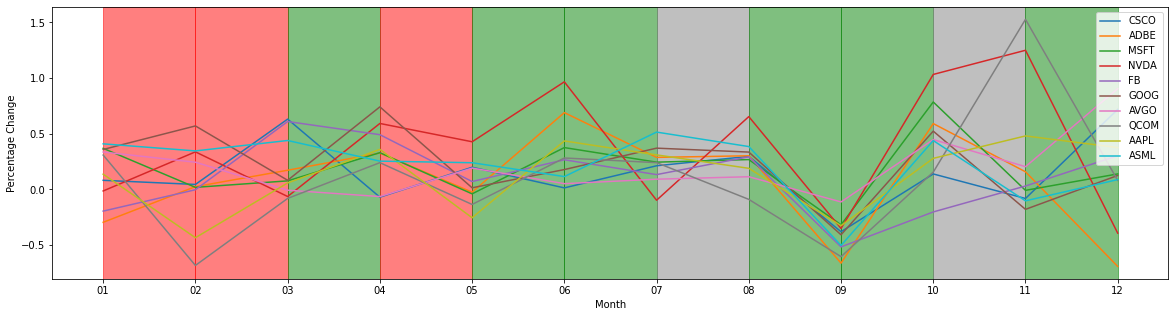

In [179]:
for name in stocks_dict.keys():
    if '.DS_Store' in name:
        continue
   
    change_price = stocks_dict[name][0]['%change']
    month = stocks_dict[name][0]['month']
    
    plt.plot(month, change_price, label = name)

for month in month_textdf['month']:
    sentiment = month_textdf.loc[month_textdf['month'] == int(month), 'sentiment'].iloc[0]
    if sentiment >= 0.168575: #any value above average is positive sentiment
        color = 'green'
    elif sentiment<=0.158991: #any value below 25 percentile is negative sentiment
        color = 'red'
    else:
        color = 'grey'
    
    if int(month) == 12:
        continue
    startx = int(month)-1
    endx = int(month)
    
    plt.axvspan(startx,endx, color = color, alpha=0.5)
    
plt.rcParams["figure.figsize"] = (20,5)
plt.ylabel('Percentage Change')
plt.xlabel('Month')
plt.legend(loc = 'upper right')

## VADER - Top 10 Stocks adjusted weekly

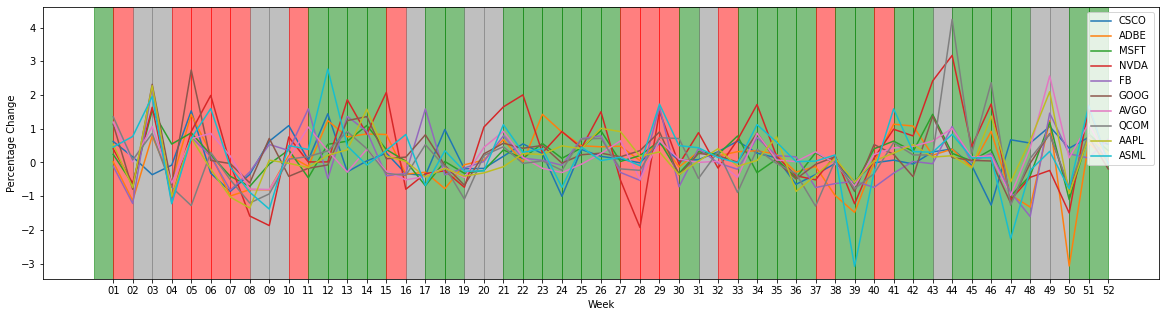

In [182]:
for name in stocks_dict.keys():
    if '.DS_Store' in name:
        continue
   
    change_price = stocks_dict[name][1]['%change']
    week = stocks_dict[name][1]['week']
    
    plt.plot(week, change_price, label = name)

for week in week_textdf['week']:
    sentiment = week_textdf.loc[week_textdf['week'] == int(week), 'sentiment'].iloc[0]
    if sentiment >= 0.172509: #any value above average is positive sentiment
        color = 'green'
    elif sentiment<=0.158376: #any value below 25 percentile is negative sentiment
        color = 'red'
    else:
        color = 'grey'
    
    if int(week) == 52:
        continue
    startx = int(week)-1
    endx = int(week)
    
    plt.axvspan(startx,endx, color = color, alpha=0.5)
    
plt.rcParams["figure.figsize"] = (20,5)
plt.ylabel('Percentage Change')
plt.xlabel('Week')
plt.legend(loc = 'upper right')

## VADER - NASDAQ monthly

In [187]:
#load NASDAQ 
nasdaq_df = pd.read_csv('historical share price/NASDAQ Index.csv')

#process dataframe
nasdaq_monthly, nasdaq_weekly = process_stock_df(nasdaq_df)

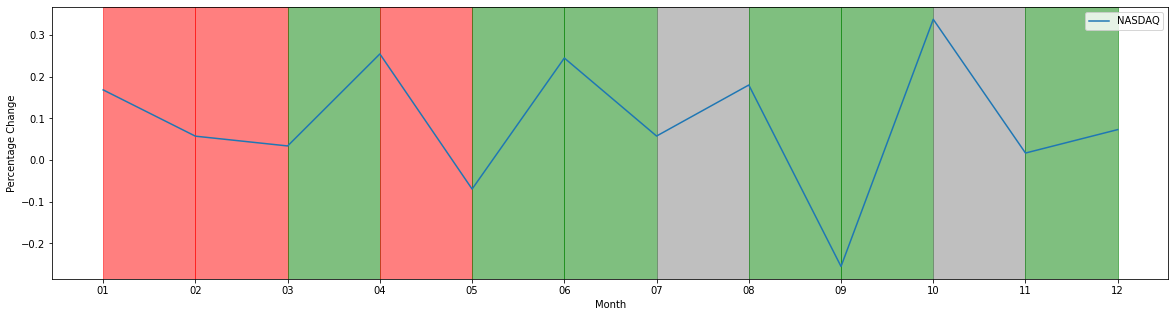

In [188]:
change_price = nasdaq_monthly['%change']
month = nasdaq_monthly['month']
    
plt.plot(month, change_price, label = 'NASDAQ')

for month in month_textdf['month']:
    sentiment = month_textdf.loc[month_textdf['month'] == int(month), 'sentiment'].iloc[0]
    if sentiment >= 0.168575: #any value above average is positive sentiment
        color = 'green'
    elif sentiment<=0.158991: #any value below 25 percentile is negative sentiment
        color = 'red'
    else:
        color = 'grey'
    
    if int(month) == 12:
        continue
    startx = int(month)-1
    endx = int(month)
    
    plt.axvspan(startx,endx, color = color, alpha=0.5)
    
plt.rcParams["figure.figsize"] = (20,5)
plt.ylabel('Percentage Change')
plt.xlabel('Month')
plt.legend(loc = 'upper right')

## VADER - NASDAQ weekly

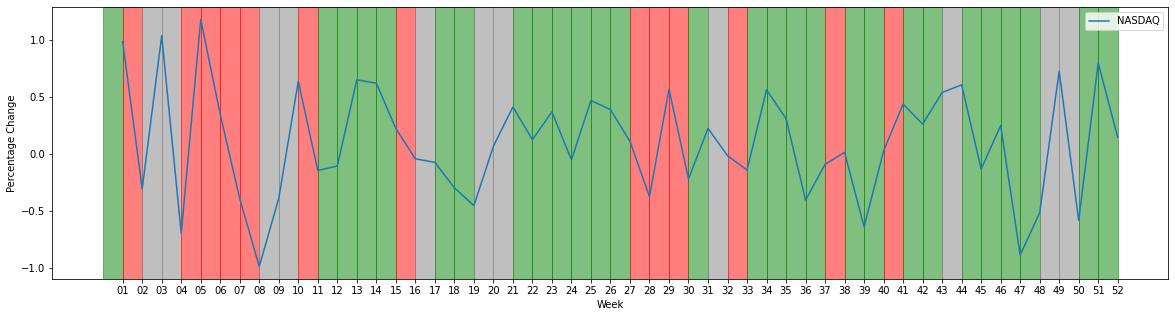

In [189]:
change_price = nasdaq_weekly['%change']
week = nasdaq_weekly['week']
    
plt.plot(week, change_price, label = 'NASDAQ')

for week in week_textdf['week']:
    sentiment = week_textdf.loc[week_textdf['week'] == int(week), 'sentiment'].iloc[0]
    if sentiment >= 0.172509: #any value above average is positive sentiment
        color = 'green'
    elif sentiment<=0.158376: #any value below 25 percentile is negative sentiment
        color = 'red'
    else:
        color = 'grey'
    
    if int(week) == 52:
        continue
    startx = int(week)-1
    endx = int(week)
    
    plt.axvspan(startx,endx, color = color, alpha=0.5)
    
plt.rcParams["figure.figsize"] = (20,5)
plt.ylabel('Percentage Change')
plt.xlabel('Week')
plt.legend(loc = 'upper right')